# Генерация кривых малоуглового рассеяния нейтронов

Напишем два класса.

В первом классе производится извлечение калибровочных параметров, присущих спектрометру малоуглового рассеяния нейтронов ЮМО. Экспериментально измеренные калибровочные образцы служат для настройки некоторых характеристик. К ним относятся разрешение детекторов спектрометра - калибровка разрешения осуществляется по образцу AgBe, дающего дифракционные пики, позиция и ширина на полувысоте которых может быть проанализирована для калибровки спектрометра; установление абсолютной шкалы рассеяния, для чего используется кремний, на который производится нормировка шкалы. Также в малоугловом рассеянии крайне важны измерения фонового образца (воды), в которой находятся исследуемые объекты. Малоугловая кривая от воды вычитается из кривой измеренного соответствующего образца для получения картины рассеяния лишь от исследуемых объектов.

Во втором классе производится генерация синтетических кривых малоуглового рассеяния нейтронов (21000 штук) на основе модели сферических оболочек (https://www.sasview.org/docs/old_docs/5.0.6/user/models/vesicle.html) с учетом полидисперсности везикул. Поскольку все кривые должны быть аналогичны реальным малоугловым кривым, в каждую кривую вводятся ошибки по интенсивности и разрешению детекторов, характерные для спектрометра ЮМО. Также вводится случайный шум, который случайно зависит от значений интенсивности рассеянных нейтронов и диапазона переданных импульсов q. Таким образом достигается аугментация кривых в определенных пределах. Кривые генерируются для разных значений
толщины липидной мембраны, радиуса везикул и полидисперсности везикул по размерам. Для облегчения фитирования таких кривых в дальнейшем, генерируется 21 батчей по 1000 кривых в каждом с одинаковым фиксированным значением полидисперсности везикул по размерам (параметра полидиспесности pd от 0.20 до 0.40 включительно в шагом 0.01). Диапазон значений толщины мембраны для сгенерированных кривых составляет от 30 до 50 ангстрем, диапазон значений радиуса везикул от 100 до 400 ангстрем, что соответствует наиболее часто встречаемым результатам и позволяет покрыть широкий диапазон различных липидов, из которых может быть составлена мембрана.

In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.signal import find_peaks, peak_widths
from scipy.signal import savgol_filter
import json
import os

Класс YUMOCalibration содержит несколько методов для загрузки заранее подготовленных калибровочных файлов, полученных из экспериментов с такими калибровочными образцами, как аргентум бихенат, кремний, пустая кювета, кювета с водой (разной толщины); также метода для калибровки разрешения по образцу аргентум бихенат - производится оценка позиции пика и его ширины на полувысоте. Файлы сохраняются.

In [ ]:
class YUMOCalibration:
    def __init__(self):
        self.flux_profile = None
        self.background_profiles = {}
        self.resolution_dq_q = 0.12
        self.absolute_scale = 1.0

    # Загрузка калибровочных и фоновых измерений
    def load_calibration_data(self, calibration_files):

    # Загрузка фоновых измерений (они уже с вычтенным прямым пучком), т.е. рассеяние от пустых кювет и воды в кювете
        background_types = ['empty_cuvette_1mm', 'empty_cuvette_2mm', 'water_1mm', 'water_2mm']
        loaded_backgrounds = 0
        for bg_type in background_types:
            if bg_type in calibration_files:
                bg_data = self._load_data_file(calibration_files[bg_type])
                if bg_data is not None:
                    self.background_profiles[bg_type] = bg_data
                    loaded_backgrounds += 1

        print(f"Загружено фоновых профилей: {loaded_backgrounds}")

       # Калибровка абсолютной шкалы по стандарту кремния
        if 'silicon_standard' in calibration_files:
            self.absolute_scale = self._calibrate_absolute_scale(calibration_files['silicon_standard'])

        # Калибровка разрешения по AgBe
        if 'agbe_standard' in calibration_files:
            self.resolution_dq_q = self._calibrate_resolution(calibration_files['agbe_standard'])

        print("Кал. данные загружены")
        print(f"Разрешение dq/q: {self.resolution_dq_q:.3f}")
        print(f"Коэффициент абс. шкалы: {self.absolute_scale:.3f}")


    # Загрузка текстовых файлов
    def _load_data_file(self, filename):
        # Файлы могут иметь разную 'шапку' и разное количество столбцов
        try:
        # Пропускаем строки до тех пор, пока не найдем числовые данные
            with open(filename, 'r') as f:
                lines = f.readlines()

            # Ищем первую строку с числовыми данными
            start_line = 0
            for i, line in enumerate(lines):
                values = line.split()
                if len(values) >= 2:
                    # Пробуем преобразовать первые два значения в float
                    try:
                        float(values[0])
                        float(values[1])
                        start_line = i
                        break
                    except ValueError:
                        # Пропускаем строки с текстом
                        continue

        # Загружаем данные, начиная с найденной строки, пропуская 'шапку файла'

            data = np.loadtxt(filename, skiprows=start_line, usecols=range(4))

            if data.shape[0] > 0 and data.shape[1] >= 2:
                result = {'q': data[:, 0], 'I': data[:, 1]}

            # Добавляем ошибку по интенсивности, если она записана в файле
                if data.shape[1] >= 3:
                    result['error'] = data[:, 2]

            # Добавляем dQ, если записан в файле
                if data.shape[1] >= 4:
                    result['dQ'] = data[:, 3]

            # Конвертируем q из обратных ангстрем в нм⁻¹
                result['q'] = result['q'] * 10  # 1 Å⁻¹ = 10 нм⁻¹

                print(f"Успешно загружен {filename}")
                return result
            else:
                raise ValueError(f"Неверный формат файла {filename}")

        except Exception as e:
            print(f"Ошибка загрузки {filename}: {e}")
            return None

    # Уровень потока нейтронов
    def _calculate_flux_profile(self, direct_beam_data):

    # Для данных после вычета прямого пучка возвращаем равномерный профиль
        return lambda q: np.ones_like(q)

    # Калибровка абсолютной шкалы по данным кремния
    # для обработанных данных коэффициент может быть ближе к 1
    # или она настраивается по известному теоретическому значению
    def _calibrate_absolute_scale(self, silicon_file):

        silicon_data = self._load_data_file(silicon_file)
        if silicon_data is None:
            return 1.0
  # или уточненный коэффициент
        return 1.0

    # Калибровка разрешения детекторов по AgBe
    def _calibrate_resolution(self, agbe_file):

        agbe_data = self._load_data_file(agbe_file)
        if agbe_data is None:
            return 0.12

        # Ручное определение пиков - вставим известные координаты, предварительно визуализировав файлы и найдя
        # положения пиков AgBe в нм⁻¹
        known_peaks_q = [1.08, 2.17, 3.28]

        peak_resolutions = []
        for peak_q in known_peaks_q:
            # Находим ближайшую точку в данных
            idx = np.argmin(np.abs(agbe_data['q'] - peak_q))

            # оценка ширины пика
            peak_intensity = agbe_data['I'][idx]
            half_max = peak_intensity / 2

            # Находим и фильтруем точки на полувысоте пика
            left_idx = np.where(agbe_data['I'][:idx] < half_max)[0]
            right_idx = np.where(agbe_data['I'][idx:] < half_max)[0]

            # Определим разрешение
            if len(left_idx) > 0 and len(right_idx) > 0:
                fwhm_q = (agbe_data['q'][idx + right_idx[0]] -
                        agbe_data['q'][left_idx[-1]])
                resolution = fwhm_q / peak_q
                peak_resolutions.append(resolution)

        return np.mean(peak_resolutions) if peak_resolutions else 0.12

        # Сохранение калибровочных параметров
    def save_calibration(self, filename):

        calibration_data = {
            'resolution_dq_q': self.resolution_dq_q,
            'absolute_scale': self.absolute_scale,
            'background_types': list(self.background_profiles.keys())
        }

        with open(filename, 'w') as f:
            json.dump(calibration_data, f, indent=2)

        print(f"Кал. параметры сохранены в {filename}")

# Инициализация
calibration = YUMOCalibration()

# Загрузка калибровочных данных
# calibration_files = {
#     'direct_beam': r"C:\Users\User\YandexDisk\ML\yumo\direct_beam.dat",
#     'empty_cuvette_1mm': r"C:\Users\User\YandexDisk\ML\yumo\empty_cell_1mm_minus_direct_beam.dat",
#     'empty_cuvette_2mm': 'data/empty_2mm.dat',
#     'water_1mm': r"C:\Users\User\YandexDisk\ML\yumo\water_1mm_minus_direct_beam.dat",
#     'silicon_standard': r"C:\Users\User\YandexDisk\ML\yumo\silicon_minus_direct_beam.dat",
#     'agbe_standard': r"C:\Users\User\YandexDisk\ML\yumo\AgBh_minus_direct_beam.dat"
# }

calibration_files = {
    'direct_beam': "/content/direct_beam.dat",
    'empty_cuvette_1mm': "/content/empty_cell_1mm_minus_direct_beam.dat",
    'empty_cuvette_2mm': "/content/empty_cell_2mm_minus_direct_beam.dat",
    'water_1mm': "/content/water_1mm_minus_direct_beam.dat",
    'silicon_standard': "/content/silicon_minus_direct_beam.dat",
    'agbe_standard': "/content/AgBh_minus_direct_beam.dat"
}


calibration.load_calibration_data(calibration_files)
calibration.save_calibration('yumo_calibration.json')

Успешно загружен /content/empty_cell_1mm_minus_direct_beam.dat
Успешно загружен /content/empty_cell_2mm_minus_direct_beam.dat
Успешно загружен /content/water_1mm_minus_direct_beam.dat
Загружено фоновых профилей: 3
Успешно загружен /content/silicon_minus_direct_beam.dat
Успешно загружен /content/AgBh_minus_direct_beam.dat
Кал. данные загружены
Разрешение dq/q: 0.233
Коэффициент абс. шкалы: 1.000
Кал. параметры сохранены в yumo_calibration.json


In [ ]:
class LipidVesicleGenerator:
    def __init__(self, calibration):
        self.calibration = calibration
        # self.q_range_angstrom = np.logspace(-2.17, -0.25, 100)
        self.q_range_angstrom = np.logspace(-2.06, -0.34, 100)
        self.q_range = self.q_range_angstrom

        #Рассчитаем относительные ошибки
    def _calculate_relative_errors(self, q, I):

        # Ошибка интенсивности: сначала уменьшается, потом возрастает

        q_optimal = np.random.normal(0.035, 0.002)  # положение минимума ошибки
        base_error = np.random.normal(0.07, 0.007)  # минимальная ошибка

        # Параболическая зависимость ошибки от q. Вид зависимости взят из реальных данных ЮМО
        error_I_rel = base_error + np.random.normal(0.05, 0.007) * (np.log(q) - np.log(q_optimal))**2

        # Добавляем случайную компоненту +-x%
        error_I_rel = error_I_rel * (np.random.normal(0.7, 0.07) + np.random.normal(0.1, 0.01) * np.random.rand(len(q)))

        # разрешение q уменьшается с ростом q
        error_q_rel = 0.15 * np.exp(-q * 8) + 0.03

        error_q_rel = error_q_rel * (0.7 + 0.07 * np.random.rand(len(q)))

        # Абсолютные ошибки
        error_I_abs = error_I_rel * I
        error_q_abs = error_q_rel * q

        return error_I_abs, error_q_abs, error_I_rel * 100, error_q_rel * 100

    # Форм-фактор для везикулы согласно модели сферических оболочек
    def vesicle_form_factor(self, q, R, thickness):

        R_outer = R + thickness/2
        R_inner = R - thickness/2

        def sphere_form_factor(q, R):
            if q == 0:
                return 1.0
            qR = q * R
            return 3 * (np.sin(qR) - qR * np.cos(qR)) / (qR**3 + 1e-15)

        V_outer = (4/3) * np.pi * R_outer**3
        V_inner = (4/3) * np.pi * R_inner**3

        F_outer = V_outer * sphere_form_factor(q, R_outer)
        F_inner = V_inner * sphere_form_factor(q, R_inner)

        delta_rho = 3.0e-6
        F_total = delta_rho * (F_outer - F_inner)
        I_q = F_total**2

        return I_q

        # Ввод и учет полидисперсности везикул с логнормальным распределением
    def polydisperse_intensity(self, q, R_mean, thickness, polydispersity=0.3):

        n_sizes = 101

        # преобразование в логарифмическую шкалу
        sigma_log = np.log(1 + polydispersity)

        # Диапазон в логарифмической шкале
        log_R_min = np.log(R_mean) - 3 * sigma_log
        log_R_max = np.log(R_mean) + 3 * sigma_log

        log_R_values = np.linspace(log_R_min, log_R_max, n_sizes)
        # обратно в линейную шкалу
        R_values = np.exp(log_R_values)

        # Веса для логнормального распределения
        weights = np.exp(-0.5 * ((log_R_values - np.log(R_mean)) / sigma_log)**2)
        weights /= np.sum(weights)

        I_total = np.zeros_like(q)
        for R, w in zip(R_values, weights):
            # Проверка: толщина должна быть меньше диаметра
            if thickness < 2 * R:
                I_total += w * self.vesicle_form_factor(q, R, thickness)
            else:
                # Если толщина слишком большая, используем минимальную возможную толщину
                feasible_thickness = min(thickness, 0.9 * 2 * R)
                I_total += w * self.vesicle_form_factor(q, R, feasible_thickness)

        return I_total

        # Генерация кривой с реалистичными ошибками
    def generate_vesicle_curve(self, thickness, radius=300, polydispersity=0.3):

        I_ideal = np.array([self.polydisperse_intensity(qi, radius, thickness, polydispersity)
                          for qi in self.q_range])

        # Нормировка всех кривых
        scale_factor = 1e10
        I_scaled = I_ideal * scale_factor

        if I_scaled[0] > 0:
            I_scaled = I_scaled * (300 / I_scaled[0])

        # Сглаживание
        I_smooth = savgol_filter(I_scaled, window_length=5, polyorder=3)

        # Фон как в реальных данных
        background_level = np.random.normal(0.03, 0.007)

        q_dependent_background = np.random.normal(0.01, 0.003) * np.exp(-self.q_range * np.random.normal(5, 0.8))
        background = background_level + q_dependent_background

        # Шум зависит от интенсивности

        I_limit_1 = abs(np.random.normal(185, 10))
        I_limit_2 = abs(np.random.normal(20, 5))
        I_limit_3 = abs(np.random.normal(0.015, 0.005))


        noise_level = np.where(I_smooth > I_limit_1, abs(np.random.normal(0.07, 0.01)),
                          np.where(I_smooth > I_limit_2, abs(np.random.normal(0.04, 0.008)),
                              np.where(I_smooth > I_limit_3, abs(np.random.normal(0.04, 0.004)),
                                       abs(np.random.normal(0.30, 0.05)))))
        I_noisy = (I_smooth + background) * (1 + noise_level * np.random.randn(len(I_smooth)))



        # фильтрация: заменяем точки, отличающиеся более чем в 10 раз от медианы по интенсивности
        # в диапазоне q от 0.1 до 0.7 A-1
        mask_range = (self.q_range_angstrom >= 0.1) & (self.q_range_angstrom <= 0.7)
        if np.any(mask_range):
            median_in_range = np.median(I_noisy[mask_range])
            outliers_mask = I_noisy < median_in_range / 10
            I_noisy[outliers_mask] = median_in_range

        # Рассчитываем ошибки
        error_I_abs, error_q_abs, error_I_rel, error_q_rel = self._calculate_relative_errors(
            self.q_range_angstrom, I_noisy
        )

        return {
            'q_angstrom': self.q_range_angstrom,
            'I': I_noisy,
            'errors_I': error_I_abs,
            'errors_q': error_q_abs,
            'errors_I_rel': error_I_rel,
            'errors_q_rel': error_q_rel,
            'thickness': thickness,
            'radius': radius,
            'polydispersity': polydispersity
        }


        # Сохранение в формате как в реальных данных
    def save_curve_to_file(self, curve, filename):

        with open(filename, 'w') as f:
            f.write("q\tI\terr I\terr q\n")
            for i in range(len(curve['q_angstrom'])):
                f.write(f"{curve['q_angstrom'][i]:.6f}\t"
                       f"{curve['I'][i]:.5f}\t"
                       f"{curve['errors_I'][i]:.5f}\t"
                       f"{curve['errors_q'][i]:.6e}\n")

        # Генерация датасета
    def generate_dataset(self, n_samples=1000, polydispersity=None):

        print(f"Генерация {n_samples} кривых...")

        dataset = []
        for i in range(n_samples):
            curve = self.generate_vesicle_curve(
                thickness=np.random.uniform(30, 50),  # разброс по толщине
                radius=np.random.uniform(100, 400),  # разброс по радиусу
                polydispersity=polydispersity  # Полидисперсия
            )
            dataset.append(curve)

            if (i + 1) % 250 == 0:
                print(f"Сгенерировано {i + 1} кривых...")

        return pd.DataFrame(dataset)

    # Сохраняет датасет в отдельные .dat файлы с q в A-1
    def save_dataset_to_files(self, dataset, output_dir="synthetic_data"):

        # Создаем директорию
        os.makedirs(output_dir, exist_ok=True)

        # Создаем файл с метаданными
        metadata = []

        for idx, row in dataset.iterrows():
            # Создаем имя файла
            filename = f"vesicle_{idx:04d}.dat"
            filepath = os.path.join(output_dir, filename)

            # Используем q в А^(-1)
            q_values = row['q_angstrom']
            I_values = row['I']
            error_values = row['errors_I']

            # Сохраняем в файл (формат: q[А^(-1)], I, error)
            with open(filepath, 'w') as f:
                # Записываем заголовок
                f.write("# Q[Å⁻¹]    I[arb.units]    Error\n")

                # Записываем данные
                for q, I, err in zip(q_values, I_values, error_values):
                    f.write(f"{q:.6e}    {I:.6e}    {err:.6e}\n")

            # Сохраняем метаданные
            metadata.append({
                'filename': filename,
                'thickness': row['thickness'],
                'radius': row['radius'],
                'polydispersity': row['polydispersity']
            })

        # Сохраняем метаданные в CSV
        metadata_df = pd.DataFrame(metadata)
        metadata_df.to_csv(os.path.join(output_dir, "metadata.csv"), index=False)

        print(f"Сохранено {len(dataset)} файлов")
        print(f"Метаданные сохранены в {output_dir}/metadata.csv")


In [ ]:
# Инициализируем генератор

generator = LipidVesicleGenerator(calibration)

Сгенерируем несколько синтетических кривых малоуглового рассеяния и их ошибки для липидных везикул разного размера,полидисперсности и толщины мембраны.

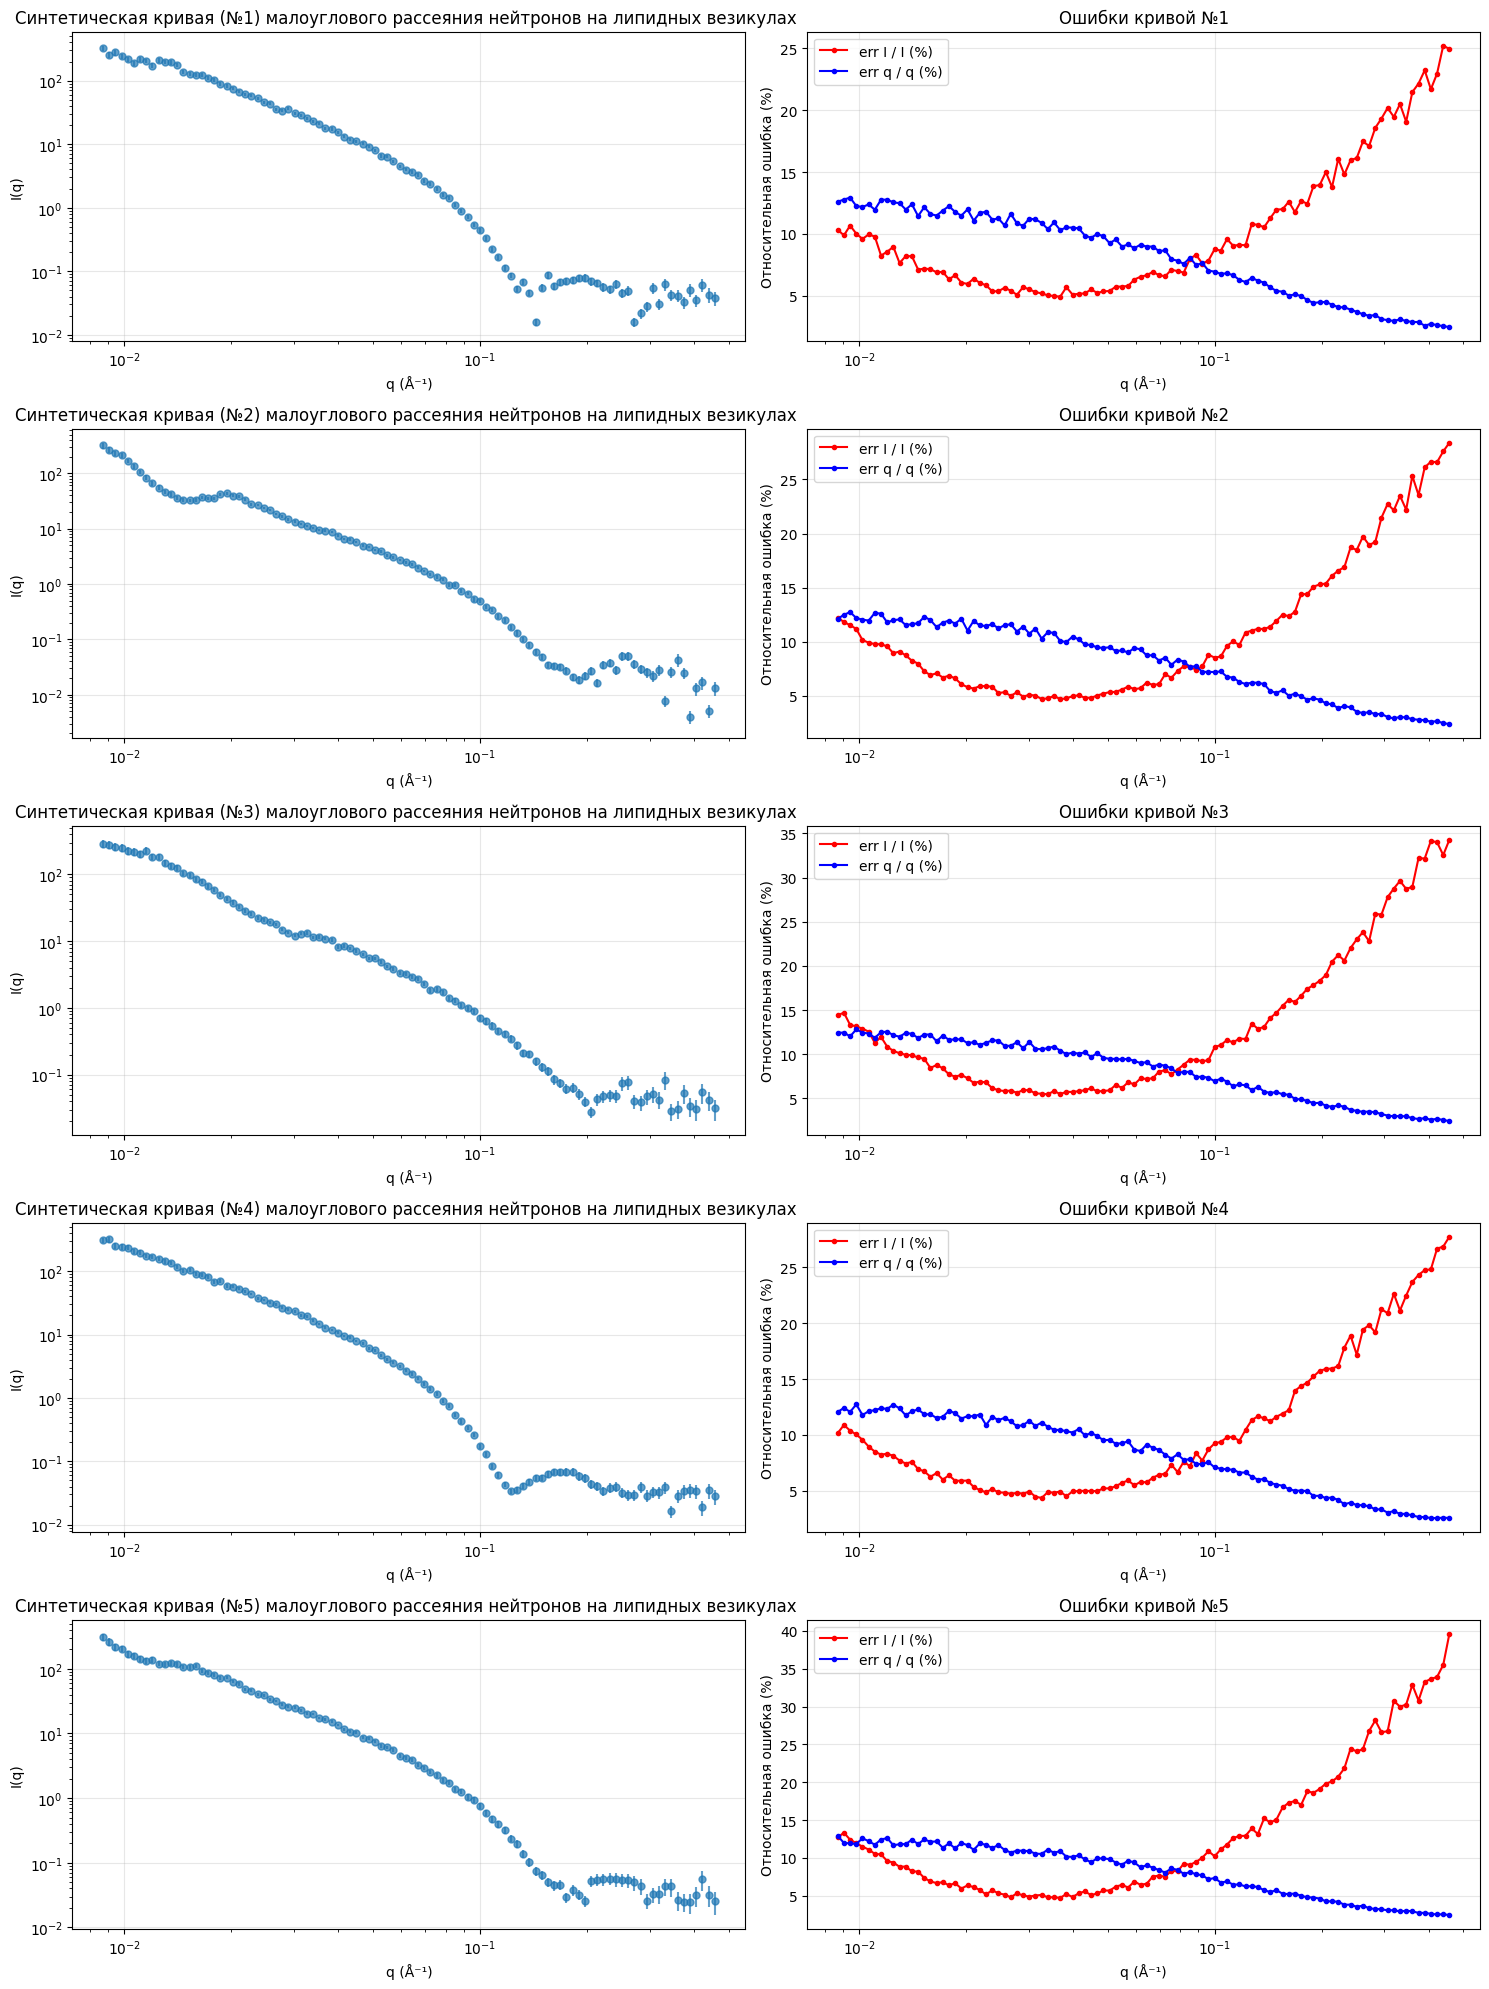

In [ ]:
curves = []

curve_1 = generator.generate_vesicle_curve(thickness=45, radius=300, polydispersity=0.3)
curves.append(curve_1)

curve_2 = generator.generate_vesicle_curve(thickness=35, radius=200, polydispersity=0.21)
curves.append(curve_2)

curve_3 = generator.generate_vesicle_curve(thickness=30, radius=100, polydispersity=0.35)
curves.append(curve_3)

curve_4 = generator.generate_vesicle_curve(thickness=50, radius=400, polydispersity=0.4)
curves.append(curve_4)

curve_5 = generator.generate_vesicle_curve(thickness=37, radius=250, polydispersity=0.3)
curves.append(curve_5)

fig, axes = plt.subplots(5, 2, figsize=(15, 20))

for i, curve in enumerate(curves):

    axes[i, 0].errorbar(curve['q_angstrom'], curve['I'],
                       yerr=curve['errors_I'], fmt='o', markersize=5, alpha=0.7)
    axes[i, 0].set_xscale('log')
    axes[i, 0].set_yscale('log')
    axes[i, 0].set_xlabel('q (Å⁻¹)')
    axes[i, 0].set_ylabel('I(q)')
    axes[i, 0].set_title(f'Синтетическая кривая (№{i+1}) малоуглового рассеяния нейтронов на липидных везикулах ')
    axes[i, 0].grid(True, alpha=0.3)

    axes[i, 1].plot(curve['q_angstrom'], curve['errors_I_rel'], 'ro-',
                   label='err I / I (%)', markersize=3)
    axes[i, 1].plot(curve['q_angstrom'], curve['errors_q_rel'], 'bo-',
                   label='err q / q (%)', markersize=3)
    axes[i, 1].set_xscale('log')
    axes[i, 1].set_xlabel('q (Å⁻¹)')
    axes[i, 1].set_ylabel('Относительная ошибка (%)')
    axes[i, 1].set_title(f'Ошибки кривой №{i+1}')
    axes[i, 1].legend()
    axes[i, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Визуально кривые малоуглового рассеяния хорошо соответствуют реальным кривым и имеют все особенности, характерные для липидных везикул с заданными параметрами.

Запустим генерацию кривых. В диапазоне параметра полидисперсности радиусов от 0.20 до 0.40 включительно с шагом 0.01 для каждого параметра полидисперсности генерируем 1000 кривых малоуглового рассеяния. Также отсортируем все возникающие файлы по убыванию радиуса везикул для облегчения анализа файлов в дальнейшем.

In [ ]:
datasets = {}
for i in range(20, 41):
    polydispersity = i / 100.0
    dataset = generator.generate_dataset(n_samples=1000, polydispersity=polydispersity)
    datasets[f"synthetic_dataset_p_{polydispersity:.2f}"] = dataset.sort_values(by='radius', ascending=False).reset_index(drop=True)

Генерация 1000 кривых...
Сгенерировано 250 кривых...
Сгенерировано 500 кривых...
Сгенерировано 750 кривых...
Сгенерировано 1000 кривых...
Генерация 1000 кривых...
Сгенерировано 250 кривых...
Сгенерировано 500 кривых...
Сгенерировано 750 кривых...
Сгенерировано 1000 кривых...
Генерация 1000 кривых...
Сгенерировано 250 кривых...
Сгенерировано 500 кривых...
Сгенерировано 750 кривых...
Сгенерировано 1000 кривых...
Генерация 1000 кривых...
Сгенерировано 250 кривых...
Сгенерировано 500 кривых...
Сгенерировано 750 кривых...
Сгенерировано 1000 кривых...
Генерация 1000 кривых...
Сгенерировано 250 кривых...
Сгенерировано 500 кривых...
Сгенерировано 750 кривых...
Сгенерировано 1000 кривых...
Генерация 1000 кривых...
Сгенерировано 250 кривых...
Сгенерировано 500 кривых...
Сгенерировано 750 кривых...
Сгенерировано 1000 кривых...
Генерация 1000 кривых...
Сгенерировано 250 кривых...
Сгенерировано 500 кривых...
Сгенерировано 750 кривых...
Сгенерировано 1000 кривых...
Генерация 1000 кривых...
Сгенериро

Визуализируем первые 5 строк одного из датасетов и выведем основную информацию.

In [ ]:
datasets[f'synthetic_dataset_p_0.21'].head()

,q_angstrom,I,errors_I,errors_q,errors_I_rel,errors_q_rel,thickness,radius,polydispersity
0,"[0.008709635899560805, 0.009065123755263397, 0...","[310.380437688049, 293.5171691026092, 292.4293...","[34.772604236725726, 32.11976847617349, 31.948...","[0.001130991211605098, 0.0010967947894549167, ...","[11.203220311092634, 10.943062913278814, 10.92...","[12.985516554855408, 12.09906030039684, 12.637...",43.767427,399.682855,0.21
1,"[0.008709635899560805, 0.009065123755263397, 0...","[316.573572862449, 296.4894226183472, 302.8589...","[40.400652624803854, 35.42428821941814, 35.779...","[0.0011074445210872699, 0.0011682313836094064,...","[12.761852563845533, 11.947909610596016, 11.81...","[12.7151643749323, 12.887098015965941, 12.0719...",35.584734,399.273640,0.21
2,"[0.008709635899560805, 0.009065123755263397, 0...","[273.0166335319094, 353.0560889719448, 331.454...","[34.74828925572795, 41.13250472533579, 40.3933...","[0.0011289497963337047, 0.0011329625438166646,...","[12.72753561063402, 11.65041646643413, 12.1866...","[12.962077971487115, 12.49803725138163, 11.867...",48.816326,399.165164,0.21
3,"[0.008709635899560805, 0.009065123755263397, 0...","[339.91828187477455, 364.79013410671524, 296.8...","[41.204540269317214, 44.432284092609, 34.89463...","[0.0010394211827402945, 0.0011095701670561196,...","[12.121895898643341, 12.180231847939956, 11.75...","[11.934151952238423, 12.239989182849053, 11.96...",42.449007,399.073770,0.21
4,"[0.008709635899560805, 0.009065123755263397, 0...","[302.97180102710314, 314.14637100621644, 303.9...","[35.429356837111314, 35.00368323992735, 33.114...","[0.0011000699395293315, 0.0011001297495278448,...","[11.693945349700016, 11.142475759885407, 10.89...","[12.630492849704588, 12.135849208777618, 12.43...",46.225861,398.630664,0.21


In [ ]:
datasets[f'synthetic_dataset_p_0.21'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   q_angstrom      1000 non-null   object 
 1   I               1000 non-null   object 
 2   errors_I        1000 non-null   object 
 3   errors_q        1000 non-null   object 
 4   errors_I_rel    1000 non-null   object 
 5   errors_q_rel    1000 non-null   object 
 6   thickness       1000 non-null   float64
 7   radius          1000 non-null   float64
 8   polydispersity  1000 non-null   float64
dtypes: float64(3), object(6)
memory usage: 70.4+ KB


Сохраним датасеты в формате csv.

In [ ]:
for i in range(20, 41):
    datasets[f'synthetic_dataset_p_0.{i}'].to_csv(f"synthetic_dataset_p_0_{i}.csv", index=False)

Сохраним в текстовые файлы все сгенерированные кривые.

In [ ]:

for i in range(20, 41):
    dataset_name = f"synthetic_dataset_p_{i/100:.2f}"
    output_dir = f"synthetic_vesicles_polydisperse_p_0_{i}"
    generator.save_dataset_to_files(datasets[dataset_name], output_dir)

Сохранено 1000 файлов
Метаданные сохранены в synthetic_vesicles_polydisperse_p_0_20/metadata.csv
Сохранено 1000 файлов
Метаданные сохранены в synthetic_vesicles_polydisperse_p_0_21/metadata.csv
Сохранено 1000 файлов
Метаданные сохранены в synthetic_vesicles_polydisperse_p_0_22/metadata.csv
Сохранено 1000 файлов
Метаданные сохранены в synthetic_vesicles_polydisperse_p_0_23/metadata.csv
Сохранено 1000 файлов
Метаданные сохранены в synthetic_vesicles_polydisperse_p_0_24/metadata.csv
Сохранено 1000 файлов
Метаданные сохранены в synthetic_vesicles_polydisperse_p_0_25/metadata.csv
Сохранено 1000 файлов
Метаданные сохранены в synthetic_vesicles_polydisperse_p_0_26/metadata.csv
Сохранено 1000 файлов
Метаданные сохранены в synthetic_vesicles_polydisperse_p_0_27/metadata.csv
Сохранено 1000 файлов
Метаданные сохранены в synthetic_vesicles_polydisperse_p_0_28/metadata.csv
Сохранено 1000 файлов
Метаданные сохранены в synthetic_vesicles_polydisperse_p_0_29/metadata.csv
Сохранено 1000 файлов
Метаданн

In [ ]:
for i in range(20, 41):
    !zip -r /content/file_p_0_{i}.zip /content/synthetic_vesicles_polydisperse_p_0_{i} -q

В этом разделе были загружены калибровочные данные, полученные на спектрометре малоуглового рассеяния ЮМО, и сгенерированы синтетические кривые малоуглового рассеяния нейтронов, которые затем будут использоваться для обучения нейросети по предсказанию толщины липидной мембраны в везикулах. Генерация кривых рассеяния была произведена на основании модели сферических оболочек с учетом шума и фона в кривых, наличием ошибок в интенсивностях и значениях q, нормировкой шкалы интенсивности, а также с учетом полидисперсности липидных везикул по радиусам. Составлены датасеты и подготовлены текстовые файлы с кривыми рассеяния для дальнейшей работы с ними - процедуры фитирования кривых.